# Assignment 1
## Problem 6 - Normalizing Flows

In [1]:
%reload_ext autoreload
%autoreload 2
#test

import matplotlib.pyplot as plt
import numpy as np
import pyro.distributions as dist
import torch
from matplotlib import cm
from src.utils.io import load_image, img_to_bw

import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as T

from src.utils.plotting import init_plot_style, show_grayscale_img
#%pylab

init_plot_style()
data_dir='../../data/img/'

C:\Users\sophi\.julia\conda\3\envs\nsp2021\lib\site-packages\torchaudio\extension\extension.py:13: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
C:\Users\sophi\.julia\conda\3\envs\nsp2021\lib\site-packages\torchaudio\backend\utils.py:89: UserWarning: No audio backend is available.
  warnings.warn('No audio backend is available.')


&ensp;
<hr style='border:2.2px solid Black'></hr>

#### Data preparation

If necessary, we first have to convert our grayscale icons to a binary image.

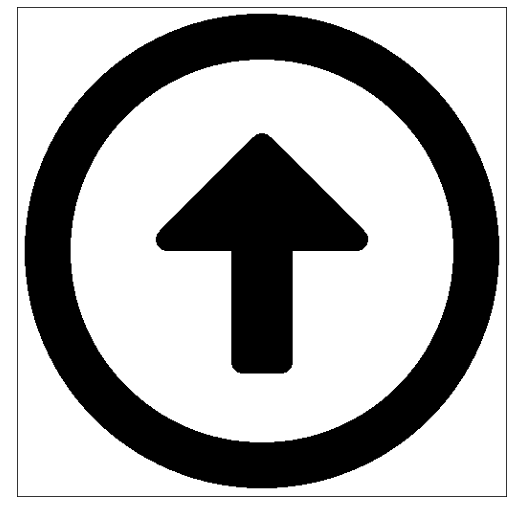

In [2]:
img = img_to_bw(data_dir + 'up.png', data_dir + 'up_bw.png')
show_grayscale_img(img)

Now we can load the binary image and generate samples from it as described in the assignment sheet.

Our image format is 512 x 512.


(0.0, 512.0)

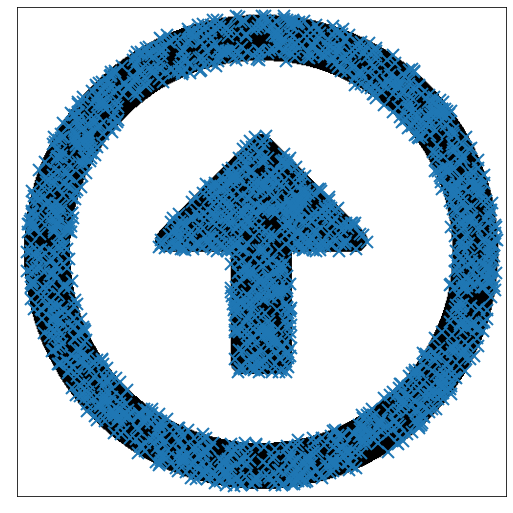

In [3]:
# load image
img = load_image(data_dir + 'up_bw.png')
height, width = img.shape
print(f'Our image format is {width} x {height}.')

# generate training samples
n_samples = 2000 # number of samples to generate
data = np.zeros((n_samples, 2))
rng = np.random.default_rng(seed=0)
i=0
while i < n_samples:
    row = rng.integers(0, height)
    col = rng.integers(0, width)
    if img[row, col] == 0:
        data[i,0] = col
        data[i,1] = row
        i += 1

# plot image with generated samples
show_grayscale_img(img)
plt.plot( data[:,0], data[:,1], 'x')
plt.xlim([0, width])
plt.ylim([0, height])


&ensp;
<hr style='border:2.2px solid Black'></hr>

### Pre-processing

Our image format is 512x512 px. But in order to further process the samples of the image efficiently using normalizing flows, the samples are normalized to [-1,1]. 

The normalizing flow is implemented using Pyro (see this [Tutorial](https://pyro.ai/examples/normalizing_flows_i.html)). For the coupling transform [`SplineCoupling`](https://docs.pyro.ai/en/stable/distributions.html#pyro.distributions.transforms.SplineCoupling) is used. The input parameter *bound=K* determines the bounding box ([−K,K]×[−K,K]) of the spline - the default value is K=3. 

The training process of the normalizing flow works efficiently when the input is normalized to [-1,1].

In [4]:
data_normalized = (data/512-0.5)*2
print(f'Our pre-processed samples lie in the range [{np.min(data_normalized)} , {np.max(data_normalized)}].')

Our pre-processed samples lie in the range [-0.9609375 , 0.9609375].


<hr style='border:1.5px solid Black'></hr>
<hr style='border:0.5px solid Gray'></hr>

### Task a) Implement a coupling flow (spline coupling flow)

<hr style='border:0.5px solid Gray'></hr>
<hr style='border:1.5px solid Black'></hr>


First, the base distribution is specified. In our case it is chosen as a random variable $X$ with the distribution of a simple multivariate Gaussian with zero mean and unit covariance matrix: 

$$ \mathbf{X} \sim \mathcal{N}(\mu = \mathbf{0}_{2x1}, \Sigma = I_{2x2}) $$

The random variable $\mathbf{X}$ is then transformed by a bijective function: $\mathbf{Y}=\mathbf{g}(\mathbf{X})$.
This base distribution $p_\mathbf{X}(\mathbf{x})$ is transformed with the *change-of-variables* formula as such: 

\begin{align}
     \log(p_\mathbf{Y}(\mathbf{y})) = \log(p_\mathbf{X}(\mathbf{g}^{-1}(\mathbf{y})))-\log\left(\det\left|\frac{d\mathbf{y}}{d\mathbf{x}}\right|\right).
\end{align}

The function $\mathbf{g}(.)$ is formed by a spline coupling layer (see [SplineCoupling](https://docs.pyro.ai/en/stable/distributions.html#splinecoupling)) with the following parameters

* *input_dim* = 2
* *hidden_dim* = [input_dim x 30 &ensp; input_dim x 30]
* *count_bins* = 32
* *bound* = 5

which led to appropriate results.

In [5]:
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
input_dim = 2
hidden_dims = [input_dim * 30, input_dim * 30]
transform = T.spline_coupling(input_dim=2, hidden_dims=hidden_dims, count_bins=32, bound=5)
flow_dist = dist.TransformedDistribution(base_dist, [transform])

**Training**:
Then the parameters of the spline-coupling layer are learnt in a stochastic gradient descent where the log-likelihood is maximized (ML principle). 

The parameters of the stochastic gradient descent are chosen as such:
* *epochs* = 2000
* *learning_rate* = 2e-2

In [6]:
steps = 2_000

dataset = torch.tensor(data_normalized, dtype=torch.float)
optimizer = torch.optim.Adam(transform.parameters(), lr=2e-2)

for step in range(steps+1):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 4.4926066398620605
step: 500, loss: 0.5422664880752563
step: 1000, loss: 0.544367253780365
step: 1500, loss: 0.48862355947494507
step: 2000, loss: 0.4424174129962921


Now that the function $\mathbf{g(.)}$ is learnt, we can sample from the trained flow distribution. The samples are shown in a scatter plot with the original b/w picture.
We can observe, that the quality of the sampling process is acceptable. Most samples lie in the correct region with some small deviation.

<Figure size 720x720 with 0 Axes>

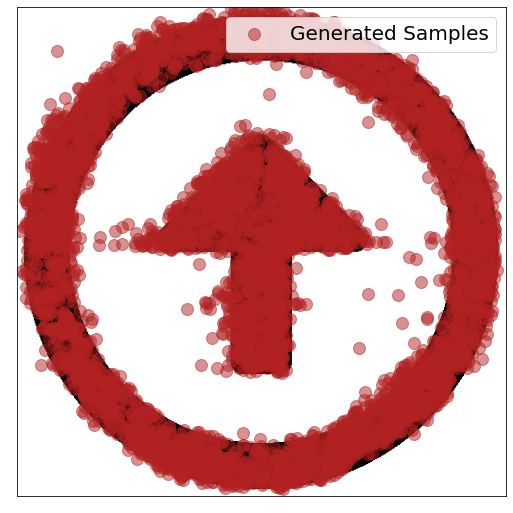

In [7]:
# generate samples from the learned distribution
samples = flow_dist.sample(torch.Size([5000,])).detach().numpy()
samples = (samples/2+0.5)*512

plt.figure(figsize=(10,10))
show_grayscale_img(img)
plt.scatter(samples[:,0], samples[:,1], color='firebrick', label='Generated Samples', alpha=0.5)
plt.xlim([0,512])
plt.ylim([0,512])
plt.legend();

We also want to have a look at the log-likelihood of our model!

Text(0, 0.5, 'Y')

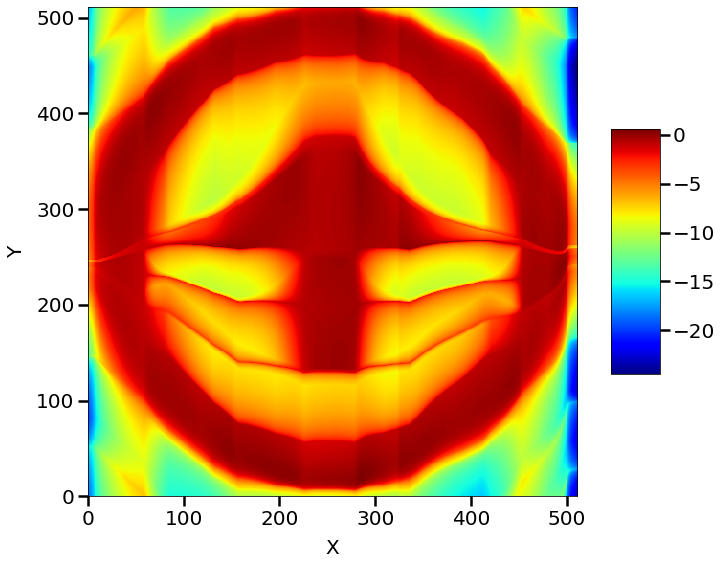

In [8]:
# compute the log-likelihood at a discrete grid
rows = np.arange(0, width)
cols = np.arange(0, height)

X, Y = np.meshgrid(cols, rows)

# flatten the grid points and evaluate their log-liklihoods
coordinates = torch.FloatTensor(np.stack((X,Y), axis=2)).view(-1, 2)
log_likelihood = flow_dist.log_prob((coordinates/512*2-1)).detach().view(-1,width).numpy()

# finally, let's plot the log-likelihood
fig, ax = plt.subplots()
levels = np.linspace(-18, 3, 20)
#surf = ax.contourf(X, Y, log_likelihood, levels=levels, cmap=cm.coolwarm, extend='min')
c = plt.imshow(log_likelihood, cmap = 'jet', vmin = np.min(log_likelihood), vmax = np.max(log_likelihood),
            extent =[X.min(), X.max(), Y.min(), Y.max()],
            interpolation ='nearest', origin ='lower')

plt.colorbar(c, shrink=0.5, aspect=5)
  
ax.set_xlabel('X')
ax.set_ylabel('Y')


### Task b) Implement an autoregressive flow (spline autoregressive flow)

In [9]:
from pyro.nn import AutoRegressiveNN

input_dim = 2
count_bins = 32
base_dist = dist.Normal(torch.zeros(input_dim), torch.ones(input_dim))
hidden_dims = [input_dim * 30, input_dim * 30]
param_dims = [count_bins, count_bins, count_bins - 1, count_bins]
hypernet = AutoRegressiveNN(input_dim, hidden_dims, param_dims=param_dims)
transform = T.SplineAutoregressive(input_dim, hypernet, count_bins=count_bins)
flow_dist = dist.TransformedDistribution(base_dist, [transform])

In [10]:
steps = 2_000

dataset = torch.tensor(data_normalized, dtype=torch.float)
optimizer = torch.optim.Adam(transform.parameters(), lr=2e-2)

for step in range(steps+1):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 2.134981393814087
step: 500, loss: 0.4952428638935089
step: 1000, loss: 0.43181687593460083
step: 1500, loss: 0.427497923374176
step: 2000, loss: 0.4017651677131653


<Figure size 720x720 with 0 Axes>

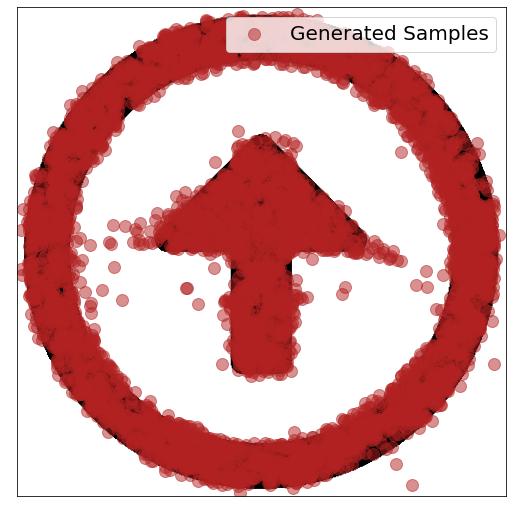

In [11]:
# generate samples from the learned distribution
samples = flow_dist.sample(torch.Size([5000,])).detach().numpy()
samples = (samples/2+0.5)*512

plt.close('all')
plt.figure(figsize=(10,10))
show_grayscale_img(img)
plt.scatter(samples[:,0], samples[:,1], color='firebrick', label='Generated Samples', alpha=0.5)
plt.xlim([0,512])
plt.ylim([0,512])
plt.legend()


Text(0, 0.5, 'Y')

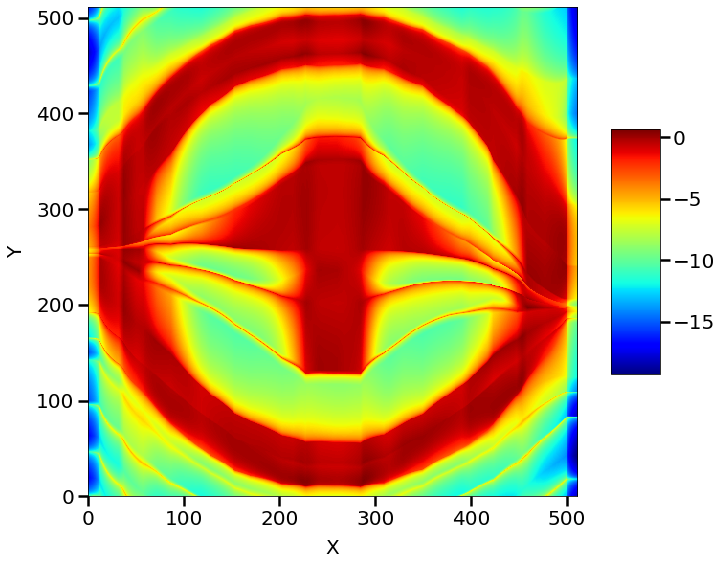

In [12]:
# compute the log-likelihood at a discrete grid
rows = np.arange(0, width)
cols = np.arange(0, height)

X, Y = np.meshgrid(cols, rows)

# flatten the grid points and evaluate their log-liklihoods
coordinates = torch.FloatTensor(np.stack((X,Y), axis=2)).view(-1, 2)
log_likelihood = flow_dist.log_prob((coordinates/512*2-1)).detach().view(-1,width).numpy()

# finally, let's plot the log-likelihood
fig, ax = plt.subplots()
levels = np.linspace(-18, 3, 20)
#surf = ax.contourf(X, Y, log_likelihood, levels=levels, cmap=cm.coolwarm, extend='min')
c = plt.imshow(log_likelihood, cmap = 'jet', vmin = np.min(log_likelihood), vmax = np.max(log_likelihood),
            extent =[X.min(), X.max(), Y.min(), Y.max()],
            interpolation ='nearest', origin ='lower')

plt.colorbar(c, shrink=0.5, aspect=5)
  
ax.set_xlabel('X')
ax.set_ylabel('Y')
